## Practice (Morphological Filter)

1. Input image from gear_tooth.png.
2. The objective is to detect missing teeth using a sequence of morphological filters.
3. Optional: Design a set of structure elements: <b>gear_body</b>, <b>sampling_ring_spacer</b>, <b>sampling_ring_width</b>, <b>tip_spacing</b>, <b>defect_cue</b>
4. Apply morphological filters using the structure elements to generate the figures (e), (f), (g), (h)
<br>&nbsp;(e) opening it with structure element <b>gear_body</b> to get rid of the teeth, dilating that with structure element <b>sampling_ring_spacer</b> to bring it out to the base of the teeth, dilating that with the structure element <b>sampling_ring_width</b> to bring the next image out to the tip of the teeth, and subtracting the last two results to get a ring that just fits over the teeth.
<br>&nbsp;(f) AND it with the original image to produce an image of just the teeth.
<br>&nbsp;(g) (optional) dilating the teeth image with the structure element <b>tip_spacing</b> produces the solid ring image which has spaces in the solid ring wherever there are defects in the teeth.
<br>&nbsp;(h) (optional) subtracting it from the sampling ring leaves only the defects, which are dilated by structure element <b>defect_cue</b>.
5. (optional) Mark the defected gears using <b>red rectangles</b> on the output images.
6. Write a simple report in a separate cell.
7. Upload your Jupyter code file (*.ipynb)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread('gear_tooth.png')

## Binary Image Processing Pipeline

### 1. Thresholding
Binary Thresholding: $\text{img\_A}(x, y) = \begin{cases} 255 & \text{if } \text{img}(x, y) \geq 225 \\ 0 & \text{otherwise} \end{cases}$

### 2. Creating Structuring Elements
- Dot-shaped kernel (kernel_dot): A small 3x3 matrix with an ellipse shape.
- Large ellipse-shaped kernel (kernel_hole): A larger 30x30 matrix with an ellipse shape.

### 3. Morphological Erosion
Eroding the Large Kernel: $\text{kernel\_hole\_e}(x, y) = \min_{(u,v) \in S} \text{kernel\_hole}(x+u, y+v)$
- $S$ is the set of coordinates defined by the shape and size of the dot-shaped kernel (kernel_dot).

### 4. Morphological Subtraction
Creating a Ring-shaped Kernel: $\text{kernel\_hole\_ring}(x, y) = \text{kernel\_hole}(x, y) - \text{kernel\_hole\_e}(x, y)$
- This operation subtracts the eroded kernel from the original kernel, resulting in a ring-shaped kernel.

### 5. Morphological Erosion
Eroding the Binary Image with the Ring-shaped Kernel: $\text{img\_B}(x, y) = \min_{(u,v) \in R} \text{img\_A}(x+u, y+v)$
- $R$ is the set of coordinates defined by the shape and size of the ring-shaped kernel (kernel_hole_ring).

### 6. Morphological Dilation
Dilating the Eroded Image with the Large Kernel: $\text{img\_C}(x, y) = \max_{(u,v) \in H} \text{img\_B}(x+u, y+v)$
- $H$ is the set of coordinates defined by the shape and size of the large kernel (kernel_hole).

### 7. Combining Images
Combining the Original Image with the Processed Image: $\text{img\_D}(x, y) = \text{img}(x, y) \, \text{OR} \, \text{img\_C}(x, y)$
- This bitwise OR operation combines the original image with the processed image, resulting in a final image that incorporates elements from both.

### Summary of Mathematical Operations
1. **Thresholding:** Converting grayscale to binary.
2. **Morphological Erosion:** Shrinking the image or kernel by a structuring element.
3. **Morphological Subtraction:** Creating a ring-shaped kernel.
4. **Morphological Erosion:** Applying the ring-shaped kernel to the binary image.
5. **Morphological Dilation:** Expanding the eroded image using a larger kernel.
6. **Bitwise OR:** Combining the original and processed images.


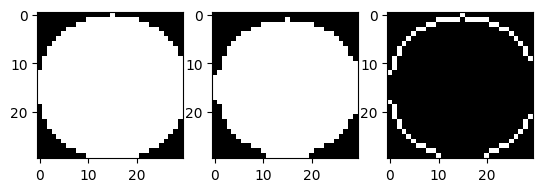

In [3]:
# Apply binary thresholding to the image
retval, img_A = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY)

# Define structuring elements
kernel_dot = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel_hole = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))

# Erode the large kernel with the small one
kernel_hole_e = cv2.erode(kernel_hole, kernel_dot, iterations=1)

# Create a ring-shaped kernel by subtracting the eroded kernel from the original
kernel_hole_ring = kernel_hole - kernel_hole_e

plt.subplot(1,3,1)
plt.imshow(kernel_hole, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(kernel_hole_e, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(kernel_hole_ring, cmap = 'gray')

# Erode the binary image with the ring-shaped kernel
img_B = cv2.erode(img_A, kernel_hole_ring, iterations=1)

# Dilate the eroded image with the large kernel
img_C = cv2.dilate(img_B, kernel_hole, iterations=1)

# Combine the original image with the processed image using bitwise OR
img_D = cv2.bitwise_or(img, img_C)

cv2.imshow('(a)', img_A)
cv2.imshow('(b)', img_B)
cv2.imshow('(c)', img_C)
cv2.imshow('(d)', img_D)

cv2.waitKey()
cv2.destroyAllWindows()

## Image Processing with Structuring Elements and Dilation Operations

In this section, we walk through a sequence of image processing steps involving structuring elements, dilation, and other morphological operations to manipulate and analyze images, specifically for isolating and enhancing image features.

#### Creating a Structuring Element

Creating an elliptical structuring element that will be used for dilation and other morphological operations:

```python
scale = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
```

This creates a 5×5 elliptical structuring element used for dilation and morphological operations.

#### Dilation Operations:
$$ 
\text{img\_dilate}(x, y) = \max_{(u,v) \in S} \text{img\_D}(x+u, y+v)
$$ 

$$
\text{img\_dilate2}(x, y) = \max_{(u,v) \in S} \text{img\_dilate}(x+u, y+v)
$$

$$
\text{img\_dilate3}(x, y) = \max_{(u,v) \in S} \text{img\_dilate2}(x+u, y+v)
$$

where SSS is the set of coordinates defined by the shape and size of the structuring element (scale). This operation dilates the image three times, expanding the white regions each time.

#### Isolate Features:
$$
\text{gear\_images}(x, y) = \text{img\_dilate2}(x, y) - \text{img\_D}(x, y)
$$

This subtracts the original processed image (img_D) from the twice-dilated image (img_dilate2) to highlight differences between them, isolating specific features.

#### Morphological Closing:
$$
\text{gear\_images\_closed}(x, y) = \max_{(u,v) \in S} \left( \min_{(u,v) \in S} \text{gear\_images}(x+u, y+v) \right)
$$

This morphological closing operation first performs an erosion followed by a dilation using the same structuring element (scale). It fills small holes and gaps in the isolated features.

#### Bitwise AND Operation:
$$
\text{Result}(x, y) = \text{gear\_images\_closed}(x, y) \, \text{AND} \, \text{img\_D}(x, y)
$$

This bitwise AND operation combines the closed image (gear_images_closed) with the original processed image (img_D), preserving the intersection of the features from both images.

In [5]:
# Define a small ellipse-shaped structuring element for scaling
scale = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

# Apply dilation to the processed image
img_dilate = cv2.dilate(img_D, scale, iterations=1)
img_dilate2 = cv2.dilate(img_dilate, scale, iterations=1)
img_dilate3 = cv2.dilate(img_dilate2, scale, iterations=1)

# Subtract the original processed image from the dilated image to isolate features
gear_images = img_dilate2 - img_D

# Apply morphological closing to the result
gear_images = cv2.morphologyEx(gear_images, cv2.MORPH_CLOSE, scale)

# Perform bitwise AND operation between the closed image and the original processed image
Result = cv2.bitwise_and(gear_images, img_D)

cv2.imshow('Input', img_D)
cv2.imshow('B1', img_dilate)
cv2.imshow('B2', gear_images)
cv2.imshow('B3', Result)

cv2.waitKey()
cv2.destroyAllWindows()

### Creating a Structuring Element

The code below creates a 20x20 rectangular structuring element. This kernel will be used for dilation, erosion, and other morphological operations.

```python
import cv2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
```
This creates a 20×20 rectangular structuring element used for dilation, erosion, and other morphological operations.

### Dilation Operation
$$
\text{img\_dilate}(x, y) = \max_{(u,v) \in S} \text{img\_D}(x+u, y+v)
$$

where SSS is the set of coordinates defined by the shape and size of the structuring element (kernel). This operation expands the white regions in the image.

### Erosion Operation
$$
\text{img\_erode}(x, y) = \min_{(u,v) \in S} \text{img\_dilate}(x+u, y+v)
$$

This operation shrinks the white regions in the dilated image, using the same rectangular structuring element.

### Morphological Opening
$$
\text{img\_open}(x, y) = \max_{(u,v) \in S} \left( \min_{(u,v) \in S} \text{img\_D}(x+u, y+v) \right)
$$

Opening is an erosion followed by a dilation. It removes small objects from the foreground (white regions).

### Morphological Closing
$$
\text{img\_open}(x, y) = \max_{(u,v) \in S} \left( \min_{(u,v) \in S} \text{img\_D}(x+u, y+v) \right)
$$

Closing is a dilation followed by an erosion. It fills small holes in the foreground (white regions).

### Morphological Gradient
$$
\text{img\_gradient}(x, y) = \max_{(u,v) \in S} \text{img\_D}(x+u, y+v) - \min_{(u,v) \in S} \text{img\_D}(x+u, y+v)
$$

The gradient operation calculates the difference between the dilation and erosion of the image, highlighting the edges.

### Top-Hat Transformation
$$
\text{img\_tophat}(x, y) = \text{img\_D}(x, y) - \left( \max_{(u,v) \in S} \left( \min_{(u,v) \in S} \text{img\_D}(x+u, y+v) \right) \right)
$$

The top-hat transformation is the difference between the original image and its opening. It highlights small bright regions on a dark background.

### Black-Hat Transformation
$$
\text{img\_blackhat}(x, y) = \left( \min_{(u,v) \in S} \left( \max_{(u,v) \in S} \text{img\_D}(x+u, y+v) \right) \right) - \text{img\_D}(x, y)
$$

The black-hat transformation is the difference between the closing of the image and the original image. It highlights small dark regions on a bright background.

In [39]:
# Define a rectangular structuring element of size 20x20
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(20,20))

# Perform dilation on the processed image using the defined kernel
img_dilate = cv2.dilate(img_D, kernel, iterations=1)

# Perform erosion on the dilated image using the same kernel
img_erode = cv2.erode(img_dilate, kernel, iterations=1)

# Perform morphological opening (erosion followed by dilation) on the processed image
img_open = cv2.morphologyEx(img_D, cv2.MORPH_OPEN, kernel)

# Perform morphological closing (dilation followed by erosion) on the processed image
img_close = cv2.morphologyEx(img_D, cv2.MORPH_CLOSE, kernel)

# Perform morphological gradient (difference between dilation and erosion) on the processed image
img_gradient = cv2.morphologyEx(img_D, cv2.MORPH_GRADIENT, kernel)

# Perform top-hat transformation (difference between the input image and the result of opening) on the processed image
img_tophat = cv2.morphologyEx(img_D, cv2.MORPH_TOPHAT, kernel)

# Perform black-hat transformation (difference between the closing of the input image and the input image) on the processed image
img_blackhat = cv2.morphologyEx(img_D, cv2.MORPH_BLACKHAT, kernel)

cv2.imshow('B7', img_blackhat)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Result

According to the result, We can find that use the method getStructuringElement in OpenCV, manipulate images according to their shapes. A structuring element is added by morphological processes to an input image to produce an output image of the same size. When performing a morphological operation, each output pixel’s value is determined by comparing it to its neighbors in the input image.

## Reference

1. https://docs.opencv.org/4.x/dd/dd7/tutorial_morph_lines_detection.html

2. https://blog.csdn.net/weixin_42512684/article/details/111087122

3. https://stackoverflow.com/questions/67117928/how-to-decide-on-the-kernel-to-use-for-dilations-opencv-python